In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing Data
df = pd.read_csv('./address_data_combined.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import time

logreg = LogisticRegression()
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',        # metric for scoring
                   cv=10)                     # number of folds
start_time = time.time()
clf.fit(X_train_full ,y_train_full)
print(time.time() - start_time)

153.36240363121033


In [4]:
import pandas as pd

# Load transactions from a CSV file
transactions_df = pd.read_csv('./transactions.csv')

# Convert the 'value' column to integers for calculation purposes
# This assumes all values in the 'value' column are numeric and can be converted to integers
transactions_df['value'] = transactions_df['value'].astype(int)

# Convert timestamps from string to datetime
transactions_df['timeStamp'] = pd.to_datetime(transactions_df['timeStamp'], unit='s')

# Calculate time differences in minutes for subsequent transactions
transactions_df.sort_values('timeStamp', inplace=True)
transactions_df['time_diff'] = transactions_df['timeStamp'].diff().dt.total_seconds() / 60

# Filter out sent and received transactions
sent_transactions = transactions_df[transactions_df['from'].str.lower() == '0x9A23A93905a0CEf884ACB6F6488BC5D7b964EF73'.lower()]
received_transactions = transactions_df[transactions_df['to'].str.lower() == '0x9A23A93905a0CEf884ACB6F6488BC5D7b964EF73'.lower()]

# Calculate various metrics with conversions from Wei to Ether
metrics = {
    'Avg min between sent tnx': sent_transactions['time_diff'].mean(),
    'Avg min between received tnx': received_transactions['time_diff'].mean(),
    'Time Diff between first and last (Mins)': (transactions_df['timeStamp'].iloc[-1] - transactions_df['timeStamp'].iloc[0]).total_seconds() / 60,
    'Unique Received From Addresses': received_transactions['from'].nunique(),
    'min value received': received_transactions['value'].min() / 1e18,
    'max value received ': received_transactions['value'].max() / 1e18,
    'avg val received': received_transactions['value'].mean() / 1e18,
    'min val sent': sent_transactions['value'].min() / 1e18,
    'avg val sent': sent_transactions['value'].mean() / 1e18,
    'total transactions (including tnx to create contract': transactions_df.shape[0],
    'total ether received': received_transactions['value'].sum() / 1e18,
    'total ether balance': transactions_df['value'].sum() / 1e18  # Simplistic balance calculation
}

In [5]:
metrics_df = pd.DataFrame([metrics])

In [6]:
for c in metrics_df.columns:
    if metrics_df[c].iloc[0] > 0:
        metrics_df[c] = np.log(metrics_df[c] + 1)

In [7]:
metrics_scaled = scaler.transform(metrics_df)

In [9]:
# Make predictions
prediction = clf.predict(metrics_scaled)

# Output the prediction
print(f"Prediction: {prediction}")

Prediction: [1]


In [4]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Train F1 Score :",clf.best_score_)
best_y_pr = clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'C': 1000.0, 'penalty': 'l2', 'solver': 'liblinear'}
Train F1 Score : 0.8355123549031308
Test F1 Score:  0.8357451129728357


In [5]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
logreg = LogisticRegression(C=1000,penalty="l1",solver='liblinear')
logreg.fit(X_train_full,y_train_full)
y_pred = logreg.predict(X_test)
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))


0.8360406091370558
0.8474636012350274
0.8420245398773006
0.8478926300918296
0.8301411290322581


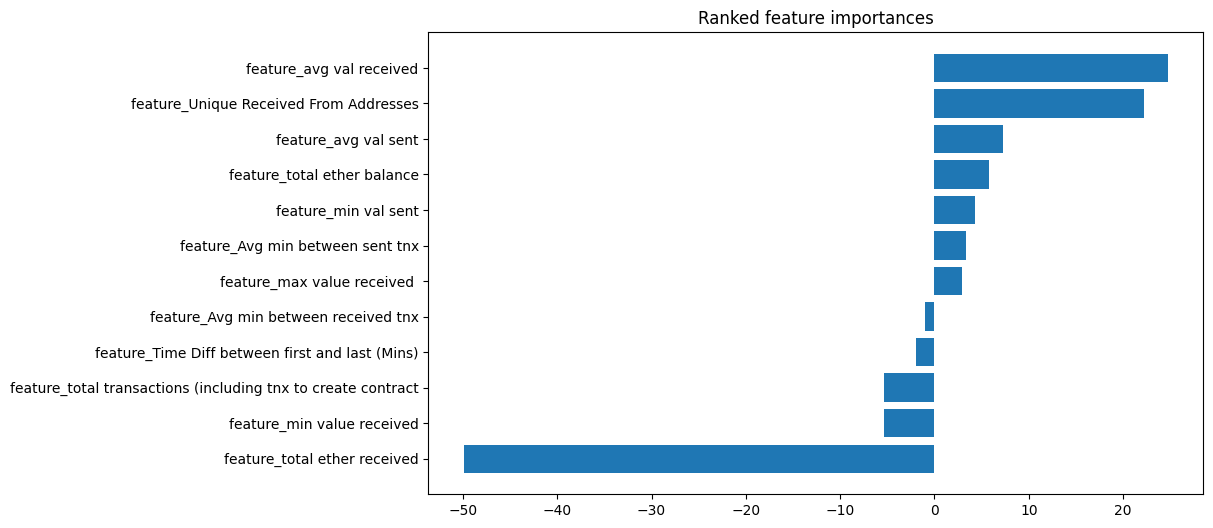

In [6]:
feat_importances = clf.best_estimator_.coef_[0]
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();